In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import CoraFull, Planetoid, CitationFull
import torch_geometric.nn as gnn 
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx, to_dense_adj

import networkx as nx

from adamp import AdamP

#from models import GPS
#from utils import test_model

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

/home/sujin/anaconda3/envs/0606/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=1)

In [19]:
import warnings
warnings.filterwarnings(action='ignore')

# Get Shotest path distance

In [14]:
dataset = CitationFull(root='dataset/Cora', name='Cora')
data = dataset[0]

In [15]:
labels = data.y.numpy()
num_node_ = []
for i in range(70):
    temp = np.where(labels == i)[0]
    num_node_.append(len(temp))

In [17]:
num_node = np.array(num_node_)
desc = num_node.argsort()[::-1]

In [ ]:
nx_graph = to_networkx(data, node_attrs=["y"])
spd_pairs_50 = dict(nx.all_pairs_shortest_path_length(nx_graph), cutoff = 50)
spd_df = pd.DataFrame.from_dict(spd_pairs_50)

spd_df.reset_index(inplace=True)
spd_df.rename(columns={'index':'dst_node'}, inplace=True)
spd_df.drop('cutoff', axis=1, inplace=True)
spd_df = pd.melt(spd_df, id_vars=['dst_node'], var_name='src_node', value_name='spd')

spd_df['src_node'] = spd_df['src_node'].apply(lambda x: int(x))
spd_df['dst_label'] = spd_df['dst_node'].apply(lambda x: data.y[x].item())
spd_df['src_label'] = spd_df['src_node'].apply(lambda x: data.y[x].item())

In [ ]:
spd_df.to_pickle('dataset/cora_spd50.pkl', index = False)
spd_df.to_parquet('dataset/cora_spd50.parquet.gzip', compression='gzip', index = False)

# Read Saved SPD

In [2]:
import modin.pandas as pd
import ray

spd_ = pd.read_pickle('/home/sujin/project/DS503/ds503/dataset/dataset/cora_spd50.pkl')

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-06-05 13:59:04,314	INFO worker.py:1625 -- Started a local Ray instance.
Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


In [ ]:
spd_[spd_['spd']==23.].shape

In [2]:
spd_.head()

,Unnamed: 0,dst_node,src_node,spd,dst_label,src_label
0,0,0,0,0.0,0,0
1,1,1227,0,1.0,11,0
2,2,4021,0,1.0,34,0
3,3,4056,0,1.0,34,0
4,4,4057,0,1.0,34,0


In [3]:
spd_.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
spd_.head()

,dst_node,src_node,spd,dst_label,src_label
0,0,0,0.0,0,0
1,1227,0,1.0,11,0
2,4021,0,1.0,34,0
3,4056,0,1.0,34,0
4,4057,0,1.0,34,0


In [17]:
label_distribution = {}
mean_ = []
num_edge_ = []
q1s = []
q3s = []
q2s = []
stats = {}
for i in range(70):
    temp = spd_[(spd_['dst_label'] == i)&(spd_['src_label'] == i)]
    label_distribution[i] = temp['spd'].tolist()
    mean_.append(temp['spd'].mean())
    num_edge_.append(len(temp))
    temp_s = pd.Series(label_distribution[0])
    q1, q2, q3 = temp_s.quantile([0.25, 0.5, 0.75])
    q1s.append(q1)
    q2s.append(q2)
    q3s.append(q3)
stats['node_id'] = list(range(10))
stats['mean'] = mean_
stats['num_edge'] = num_edge_
stats['num_node'] = num_node_
stats['q1'] = q1s
stats['q2'] = q2s
stats['q3'] = q3s
stats_df = pd.DataFrame(stats)

ValueError: All arrays must be of the same length

In [33]:
stats_df.sort_values(by='num_node', ascending=False).to_excel('dataset/cora_stats.xlsx', index=False)

In [55]:
spd_.dropna(inplace=True)

In [ ]:
label_num_order = spd_['dst_label'].value_counts(ascending = False).index.tolist()

# informatio to ratio

In [5]:
spd_.head()

,dst_node,src_node,spd,dst_label,src_label
0,0,0,0.0,0,0
1,1227,0,1.0,11,0
2,4021,0,1.0,34,0
3,4056,0,1.0,34,0
4,4057,0,1.0,34,0


In [6]:
total = pd.DataFrame()
for dst in range(70):
    temp = spd_[spd_['dst_label'] == dst]
    temp['is_same'] = temp['src_label'].apply(lambda x: 1 if x == dst else 0)
    temp = temp.groupby('spd').agg({'is_same':'sum', 'src_node':'count'}).reset_index()
    temp.rename(columns={'src_node':'num_node'}, inplace=True)
    temp['dst_node'] = dst
    total = pd.concat([total, temp], axis=0)

In [7]:
total.head()

,spd,num_node,is_same,dst_node
0,0.0,257,257,0
1,1.0,1533,838,0
2,2.0,13013,4208,0
3,3.0,68765,11430,0
4,4.0,308271,18228,0


In [13]:
total.to_pickle('dataset/cora_spd50_itn.pkl')

In [10]:
total = total.astype({'num_node':'float64'})

In [22]:
total_ = total[total['spd'] != 0.0]

57 928


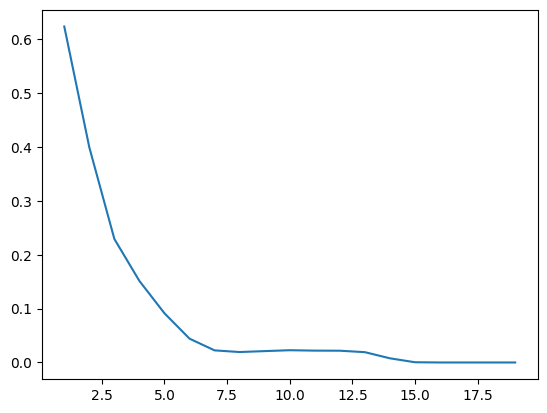

33 855


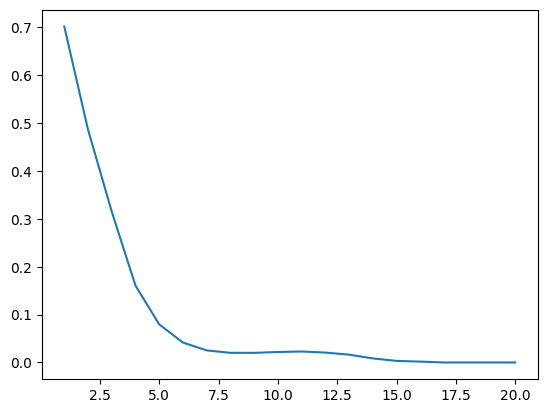

27 783


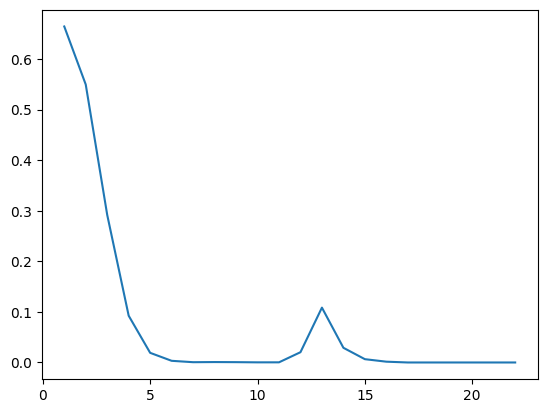

7 663


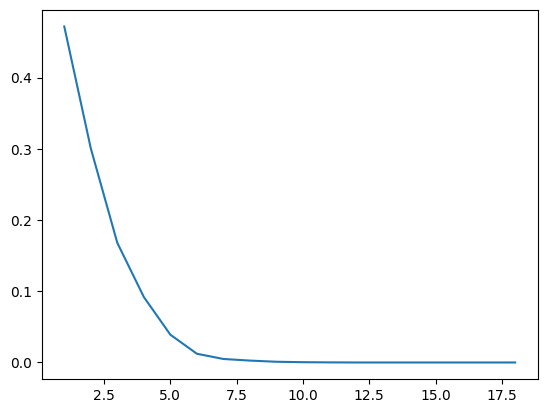

53 650


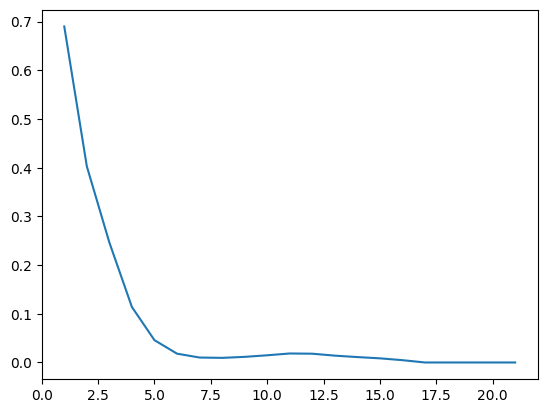

51 625


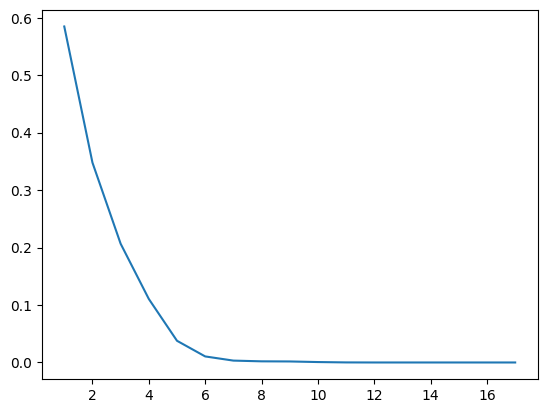

34 576


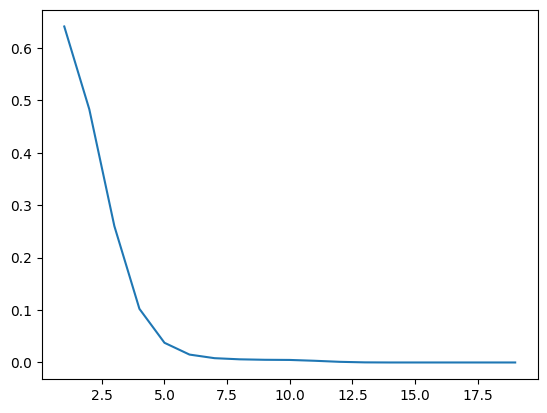

39 564


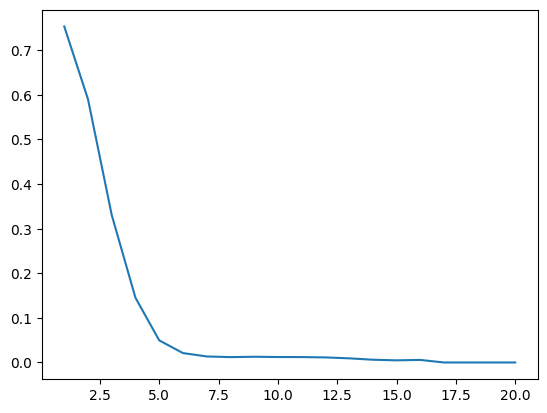

48 557


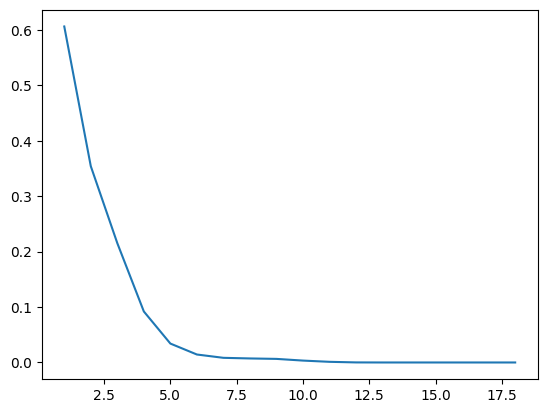

13 521


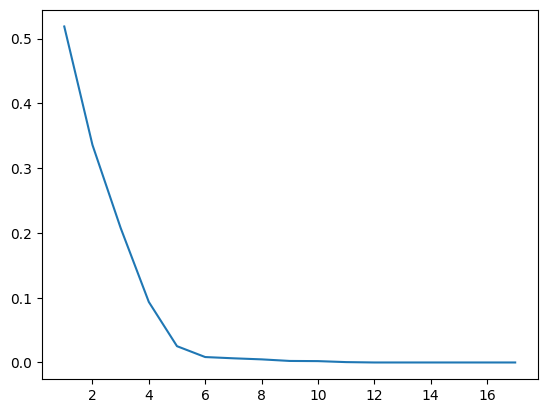

52 501


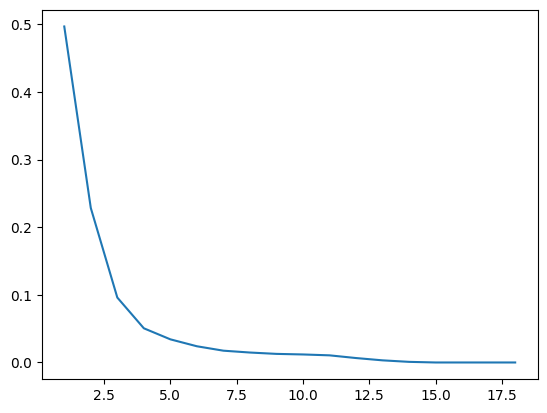

55 473


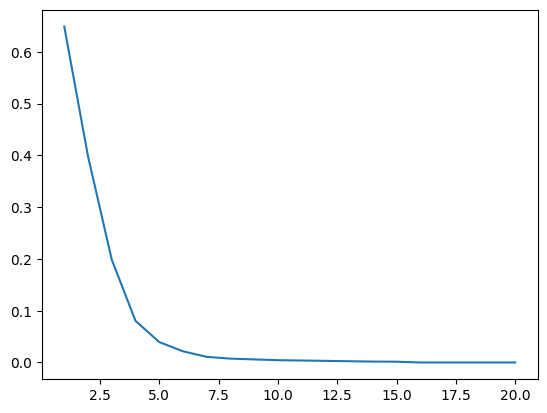

29 466


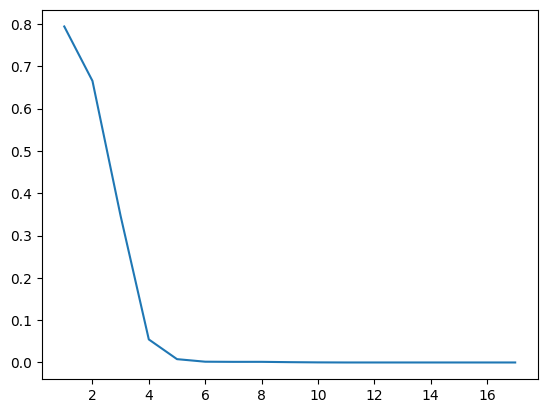

19 435


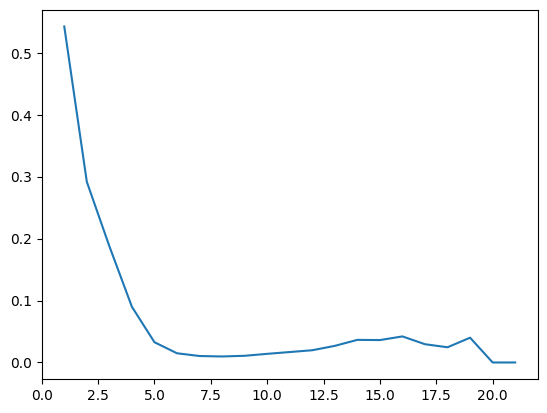

20 420


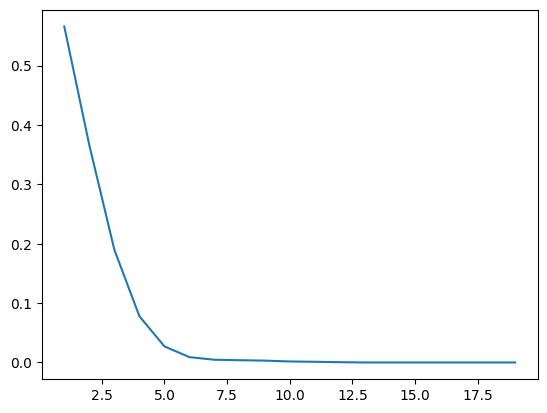

22 414


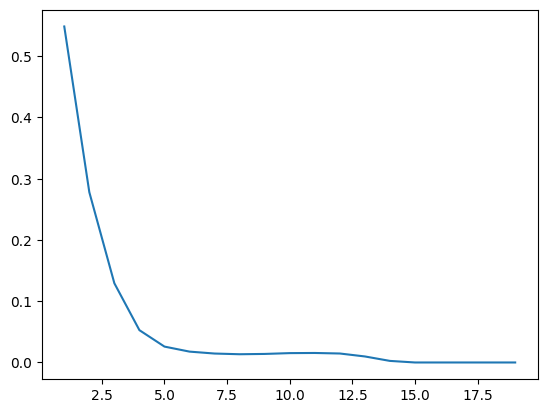

6 404


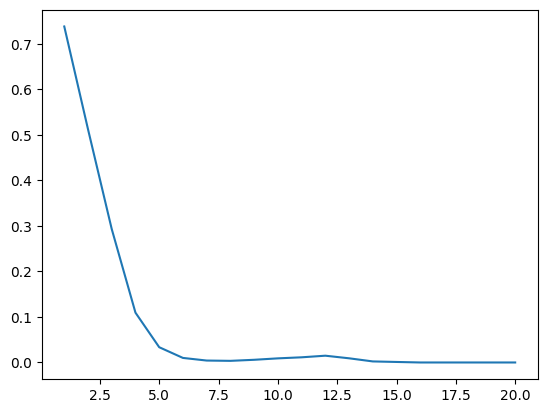

3 378


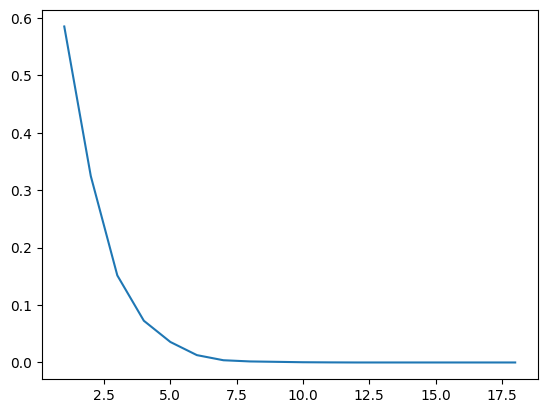

31 376


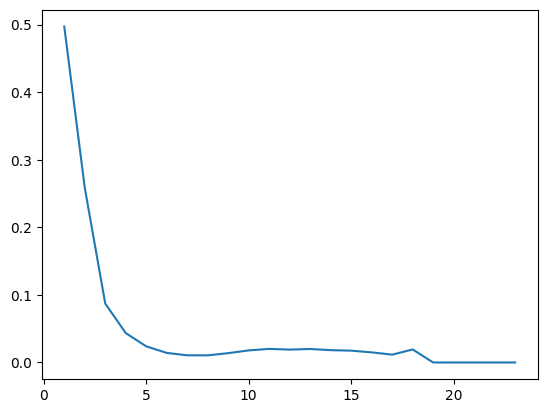

45 370


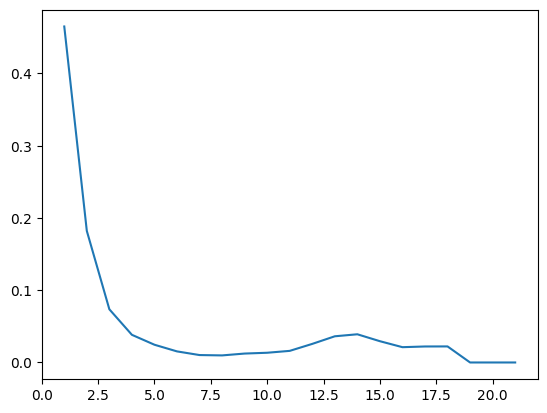

9 342


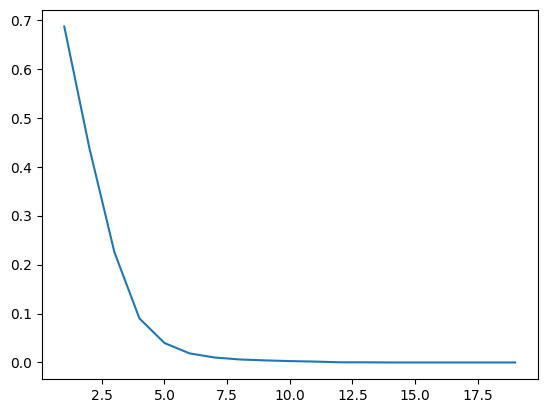

14 341


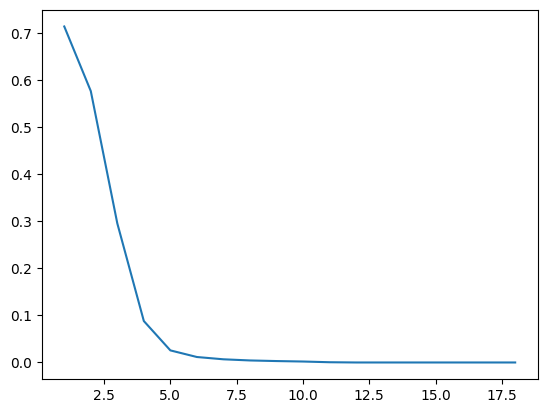

24 334


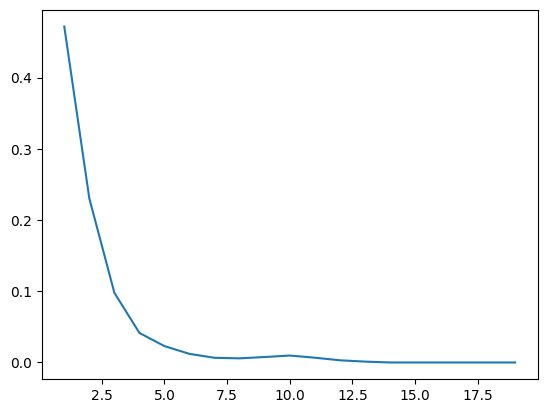

56 324


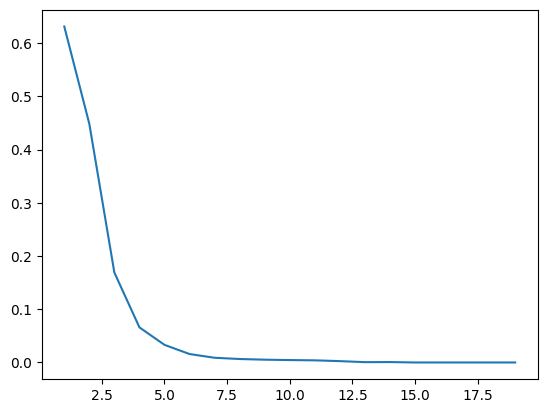

25 315


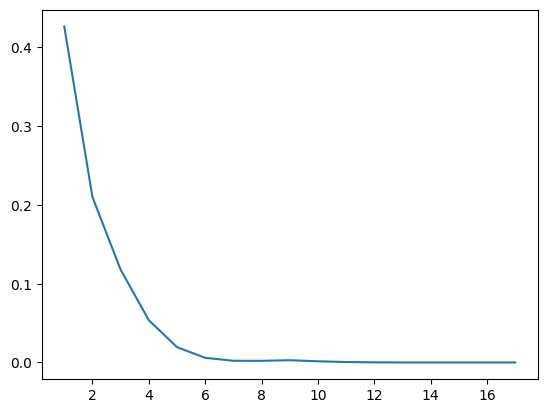

5 305


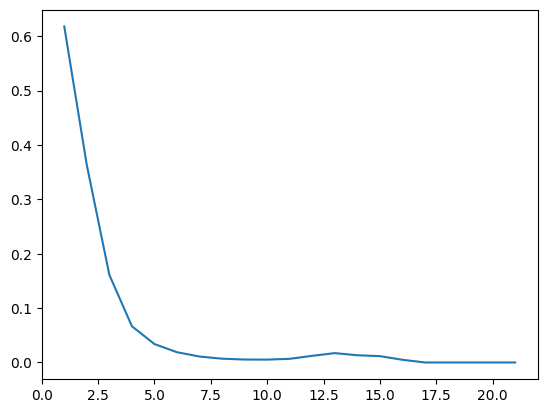

59 301


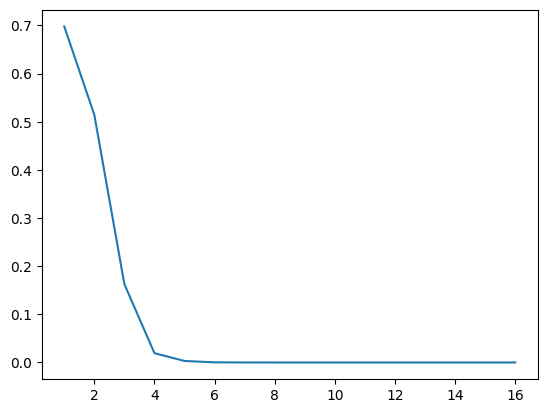

36 293


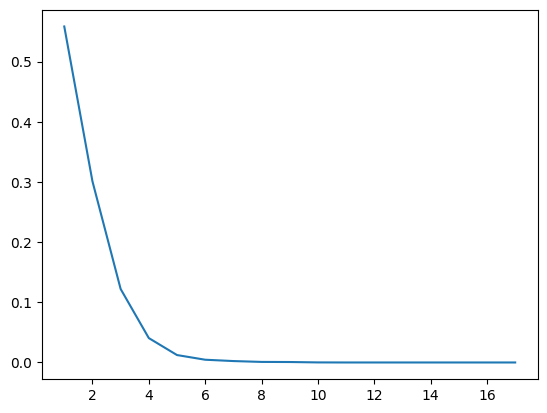

63 291


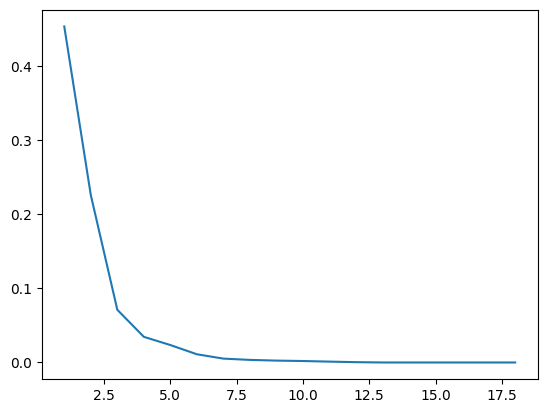

49 285


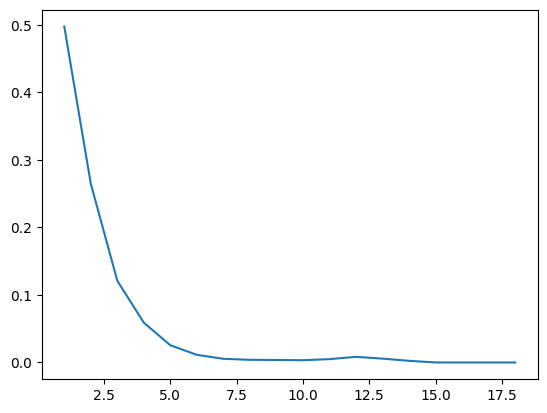

26 284


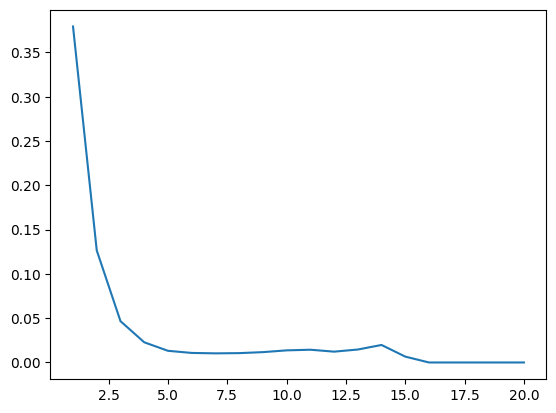

40 280


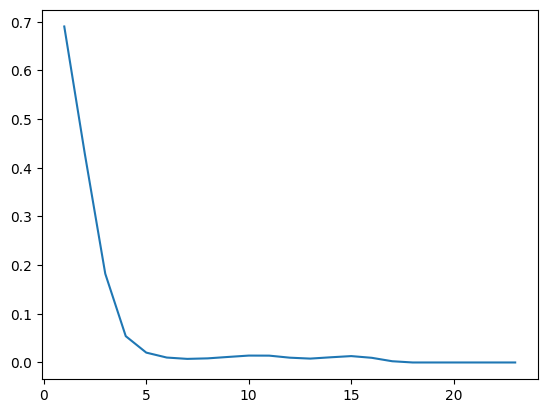

0 257


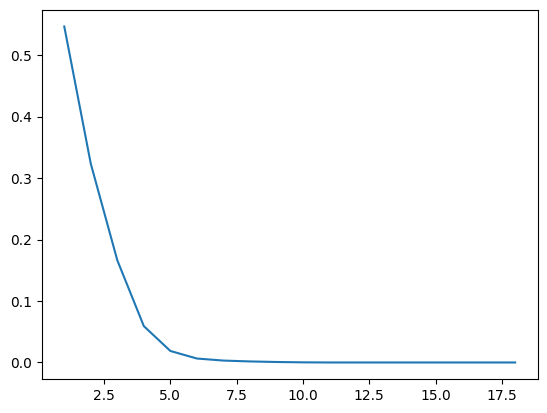

21 254


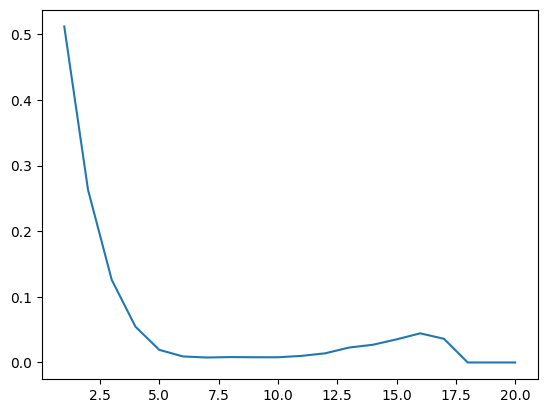

2 243


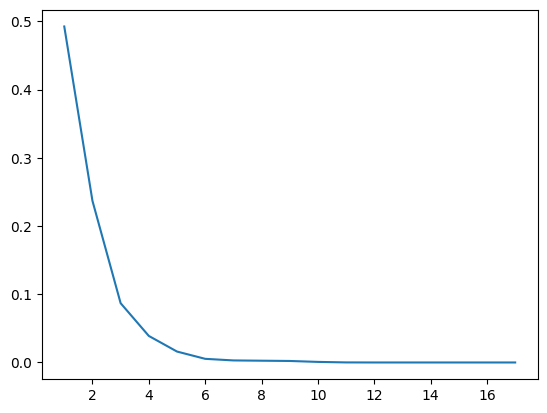

8 240


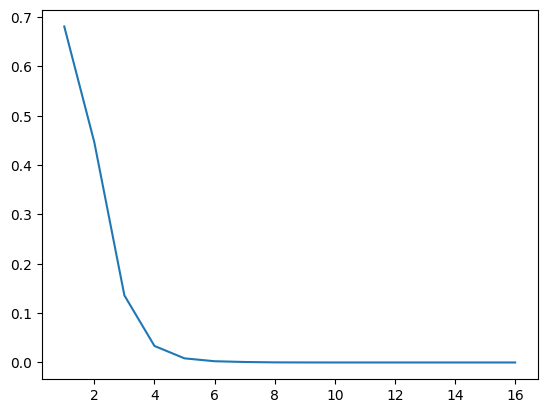

11 223


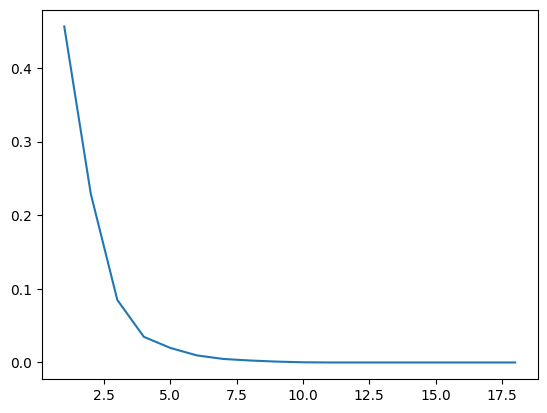

30 221


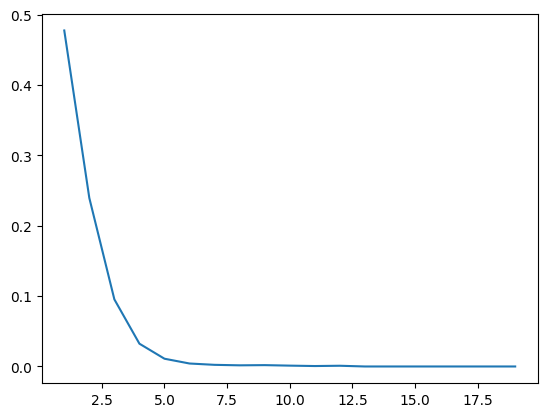

61 220


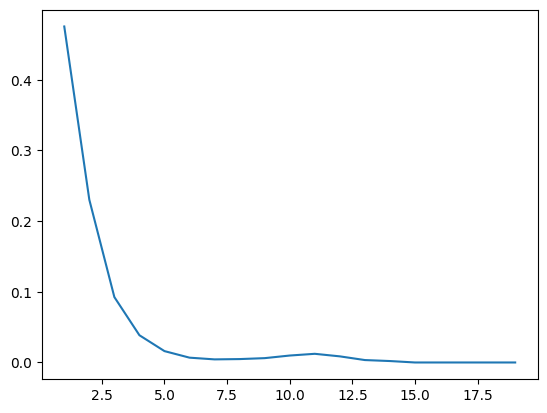

58 212


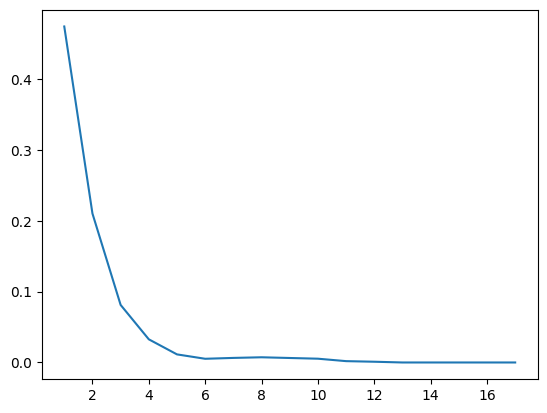

41 205


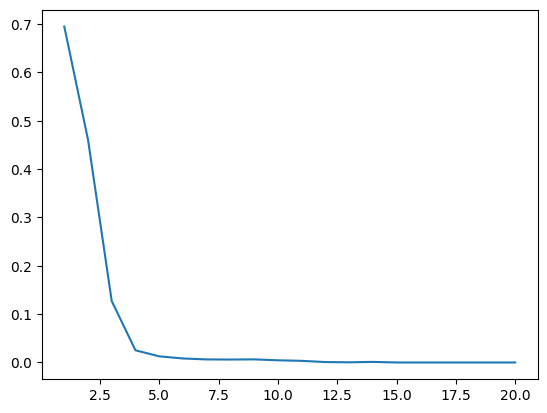

23 196


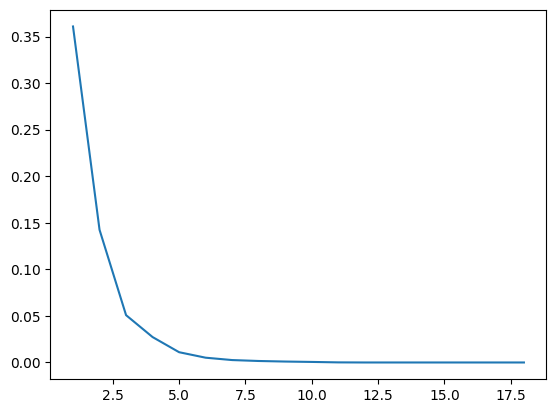

62 165


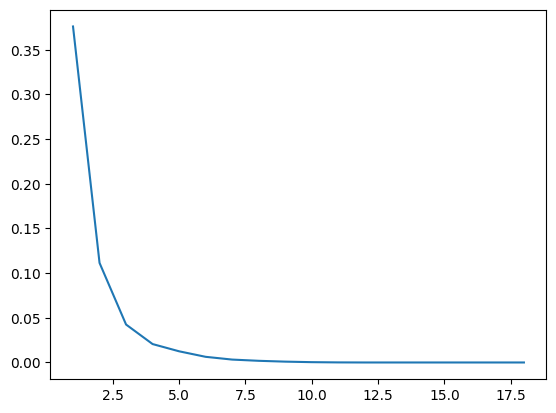

37 163


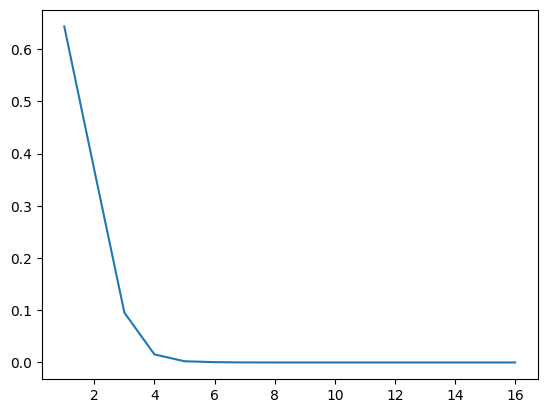

32 154


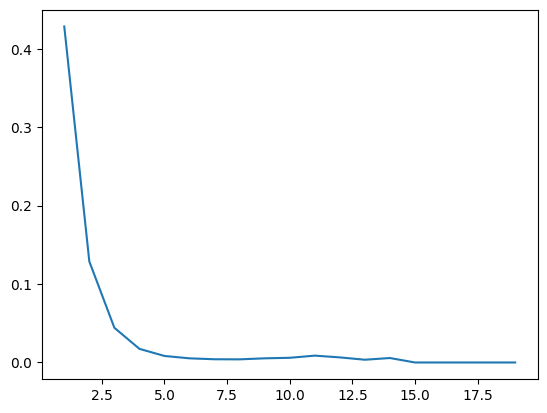

64 147


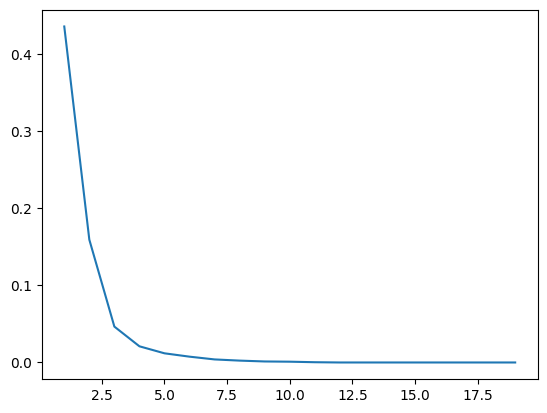

10 141


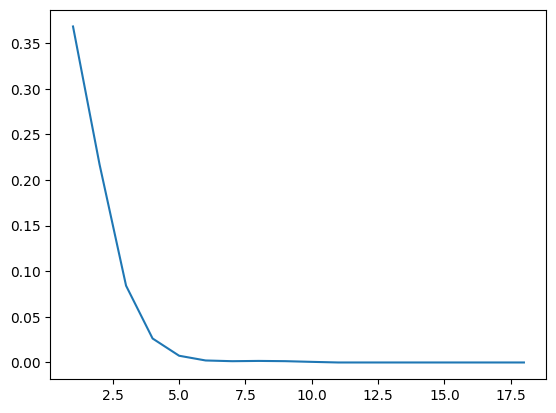

15 138


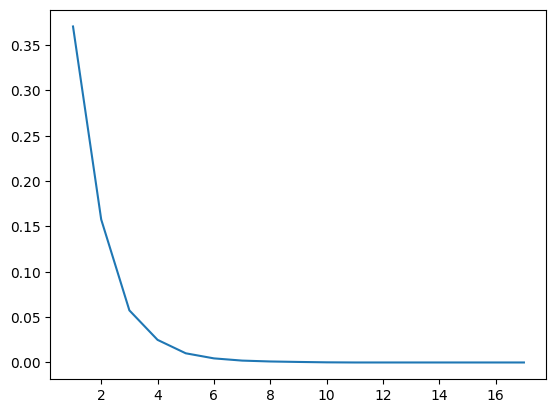

66 137


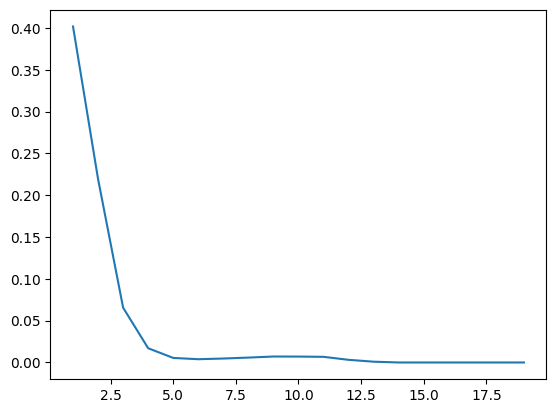

44 129


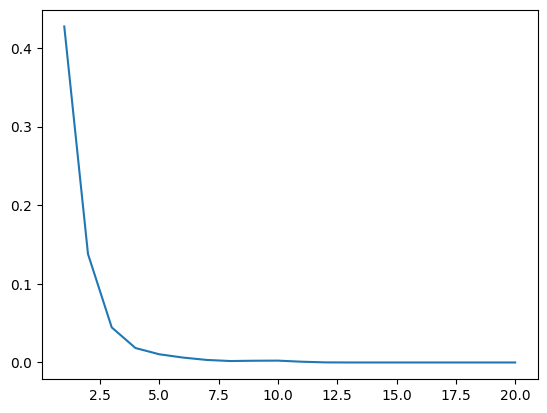

38 125


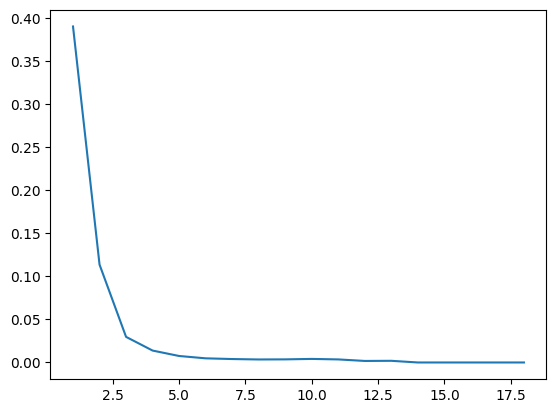

46 122


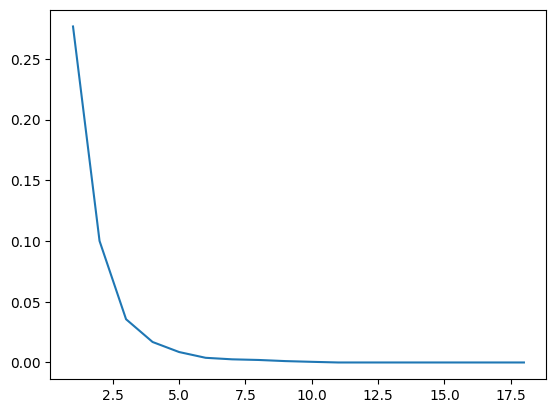

60 116


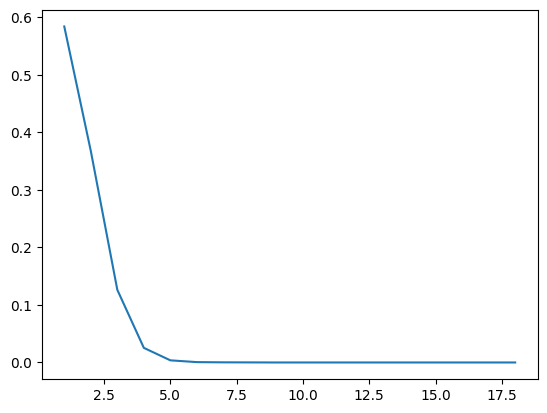

16 115


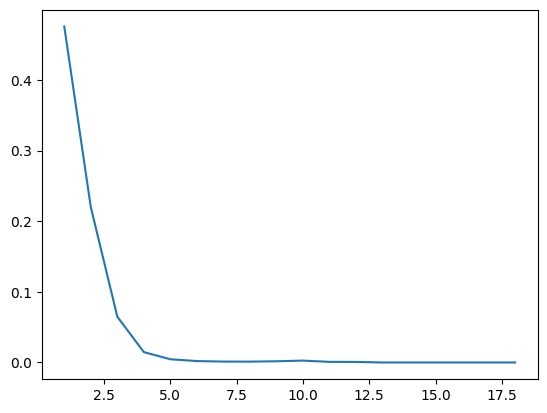

28 113


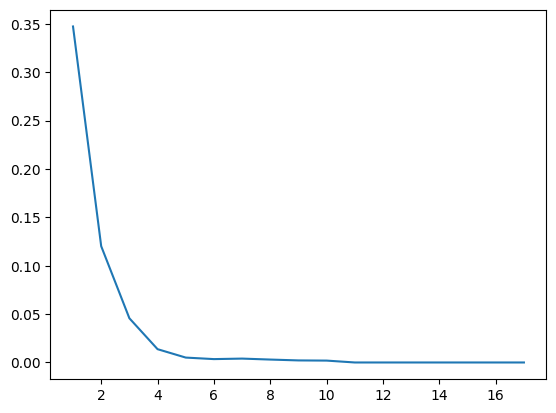

17 111


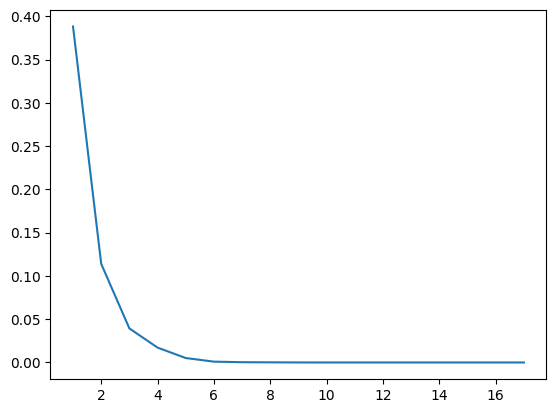

12 102


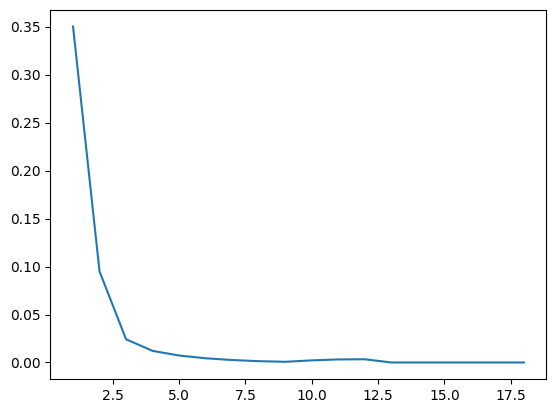

54 99


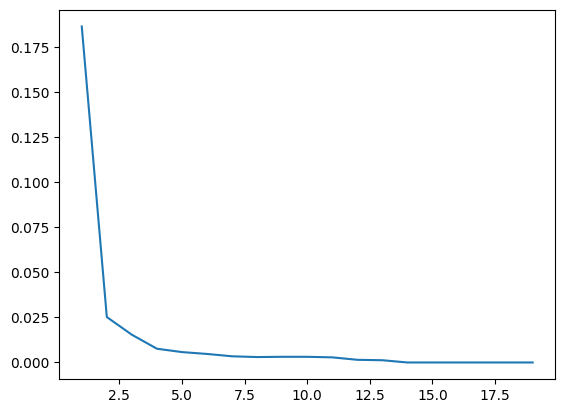

42 94


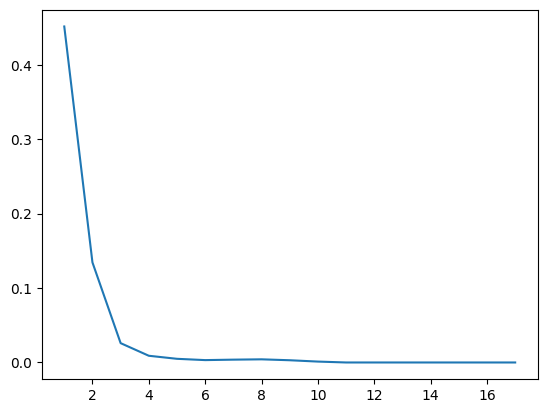

65 91


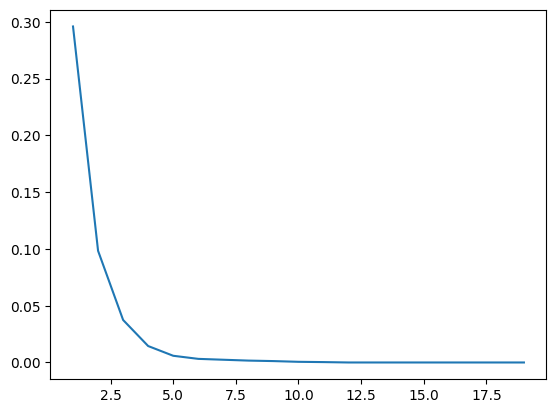

35 84


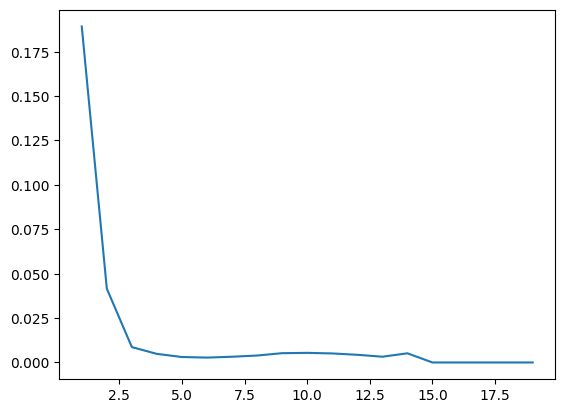

67 84


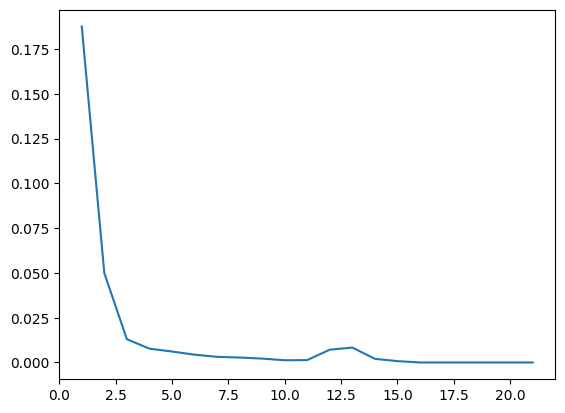

18 80


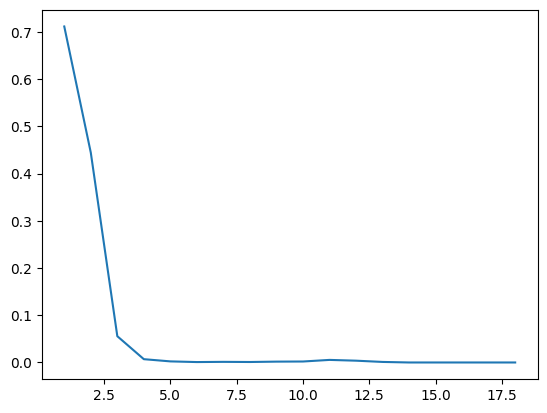

47 74


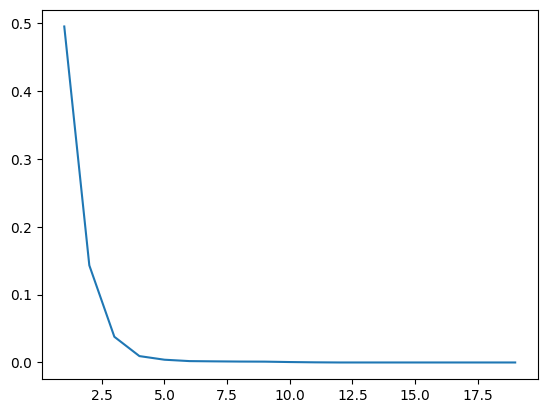

50 72


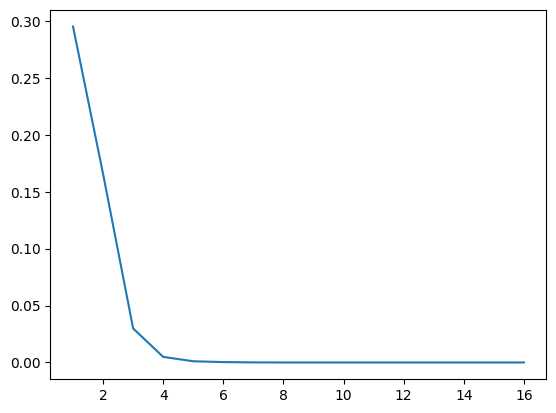

4 63


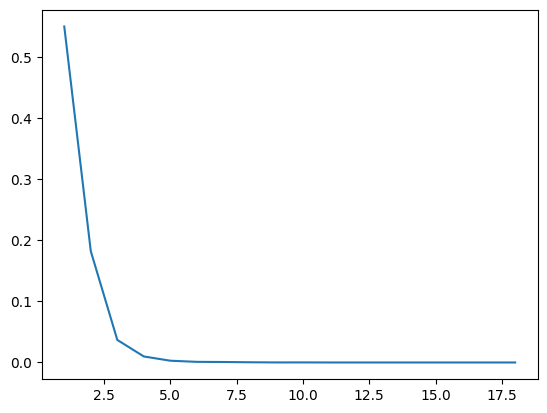

43 53


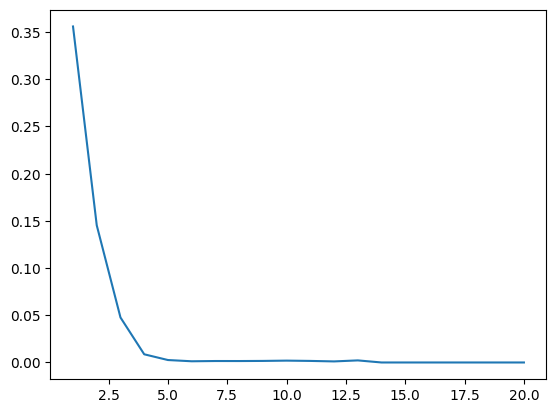

1 52


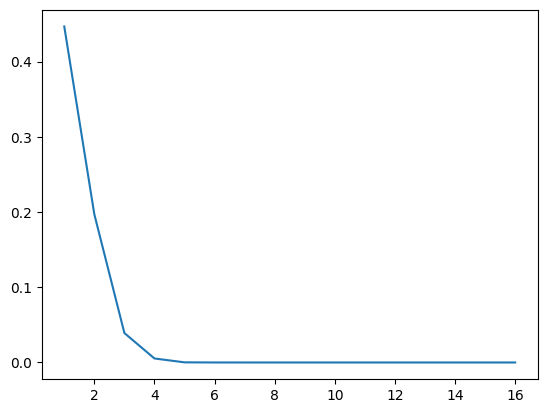

69 29


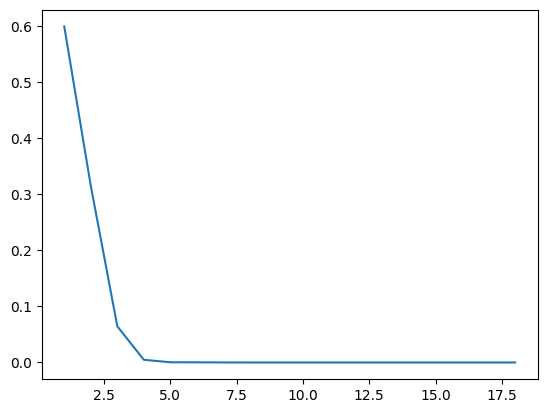

68 15


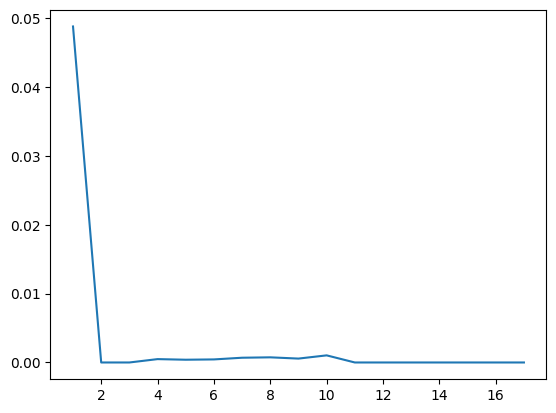

In [24]:
for i in desc:
    temp = total_[total_['dst_node'] == i]
    temp['ratio'] = temp['is_same'] / temp['num_node']
    print(i, num_node[i])
    plt.plot(temp['spd'], temp['ratio'], label = i)
    plt.show()


In [26]:
for i in desc:
    temp = total_[total_['dst_node'] == i]
    temp['ratio'] = temp['is_same'] / temp['num_node']
    print(i, num_node[i])
    print(temp[['spd','ratio']].head())

57 928
   spd     ratio
1  1.0  0.623395
2  2.0  0.399109
3  3.0  0.229111
4  4.0  0.151218
5  5.0  0.091272
33 855
   spd     ratio
1  1.0  0.701824
2  2.0  0.486555
3  3.0  0.315248
4  4.0  0.160673
5  5.0  0.079611
27 783
   spd     ratio
1  1.0  0.664168
2  2.0  0.549460
3  3.0  0.291769
4  4.0  0.092421
5  5.0  0.019059
7 663
   spd     ratio
1  1.0  0.471710
2  2.0  0.300652
3  3.0  0.167921
4  4.0  0.091922
5  5.0  0.038998
53 650
   spd     ratio
1  1.0  0.690079
2  2.0  0.402986
3  3.0  0.246393
4  4.0  0.113957
5  5.0  0.045856
51 625
   spd     ratio
1  1.0  0.584850
2  2.0  0.347913
3  3.0  0.206717
4  4.0  0.110575
5  5.0  0.037768
34 576
   spd     ratio
1  1.0  0.641104
2  2.0  0.482975
3  3.0  0.260188
4  4.0  0.102371
5  5.0  0.037585
39 564
   spd     ratio
1  1.0  0.753370
2  2.0  0.590178
3  3.0  0.330555
4  4.0  0.145117
5  5.0  0.049622
48 557
   spd     ratio
1  1.0  0.606176
2  2.0  0.354113
3  3.0  0.215225
4  4.0  0.092014
5  5.0  0.034124
13 521
   spd     ra

In [27]:
temp

,spd,num_node,is_same,dst_node,ratio
1,1.0,41.0,2,68,0.048780
2,2.0,452.0,0,68,0.000000
3,3.0,3102.0,0,68,0.000000
4,4.0,12292.0,6,68,0.000488
5,5.0,30025.0,12,68,0.000400
6,6.0,49552.0,22,68,0.000444
7,7.0,60932.0,42,68,0.000689
8,8.0,42847.0,32,68,0.000747
9,9.0,17683.0,10,68,0.000566
10,10.0,5814.0,6,68,0.001032


# Get n hop

In [ ]:
dense = to_dense_adj(data.edge_index)

In [ ]:
temp = torch.linalg.matrix_power(dense, 23)

In [ ]:
temp.shape

torch.Size([1, 19793, 19793])

In [ ]:
temp[temp==0].shape

torch.Size([38320400])